In [1]:
import sys
sys.path.append('../../MembraneQuant')
from membranequant import *
import seaborn as sns
%matplotlib notebook

## AF settings

[2.008510101149113, -1314.2861555087666]


<IPython.core.display.Javascript object>


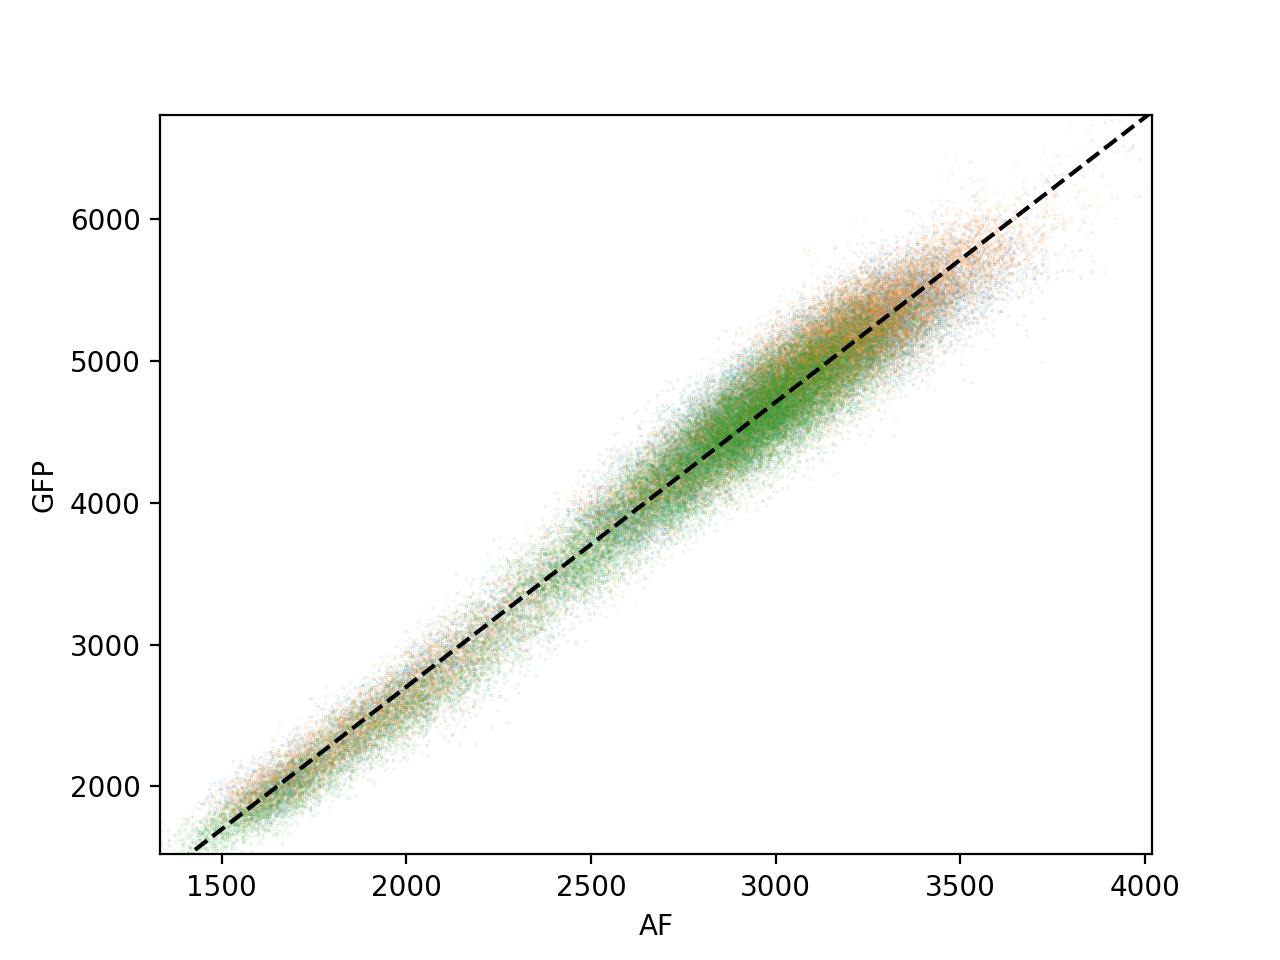

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='AF', ylabel='GFP'>)

In [2]:
n2_path = '/Users/blandt/Desktop/Analysis/Experiments/e2107__gcn4/210722_n2_tom4,15,60'

af = AfCorrelation(direcslist(n2_path, 0), sigma=1, expand=10)
af.run()
print(af.params)

af.plot_correlation()

## Load data

In [4]:
path = '/Users/blandt/Desktop/Analysis/Experiments/e2107__gcn4'
direcs = direcslist(path, 1)

imgs = []
for d in direcs:
    ch1 = load_image(glob.glob(d + '/*488 SP 535-50*')[0])
    ch2 = load_image(glob.glob(d + '/*488 SP 630-75*')[0])
    img = af_subtraction(ch1, ch2, *af.params)
    imgs.append(img)
    save_img(img, d + '/af_corrected.tif')
    
rois = [np.loadtxt(d + '/ROI.txt') for d in direcs]

cytbg = np.loadtxt('../GCN4 PAR-2/cyt_profile.txt')
membg = np.loadtxt('../Par2 rundown/membg.txt')

## Run quantification

In [5]:
iq = ImageQuant(img=imgs, roi=rois, cytbg=cytbg, membg=membg, uni_cyt=True, descent_steps=1000, freedom=20, 
                iterations=2, rol_ave=10)

# iq = ImageQuant(img=imgs, roi=rois, cytbg=cytbg, membg=membg, uni_cyt=False, descent_steps=1000, freedom=20, 
#                 iterations=2, rol_ave=10)

# iq = ImageQuant(img=imgs, roi=rois, descent_steps=1000, freedom=20, iterations=2, rol_ave=10, bg_subtract=True)

In [6]:
iq.run()

100%|██████████| 1000/1000 [01:22<00:00, 12.16it/s]


Time elapsed: 166.88 seconds 


<IPython.core.display.Javascript object>


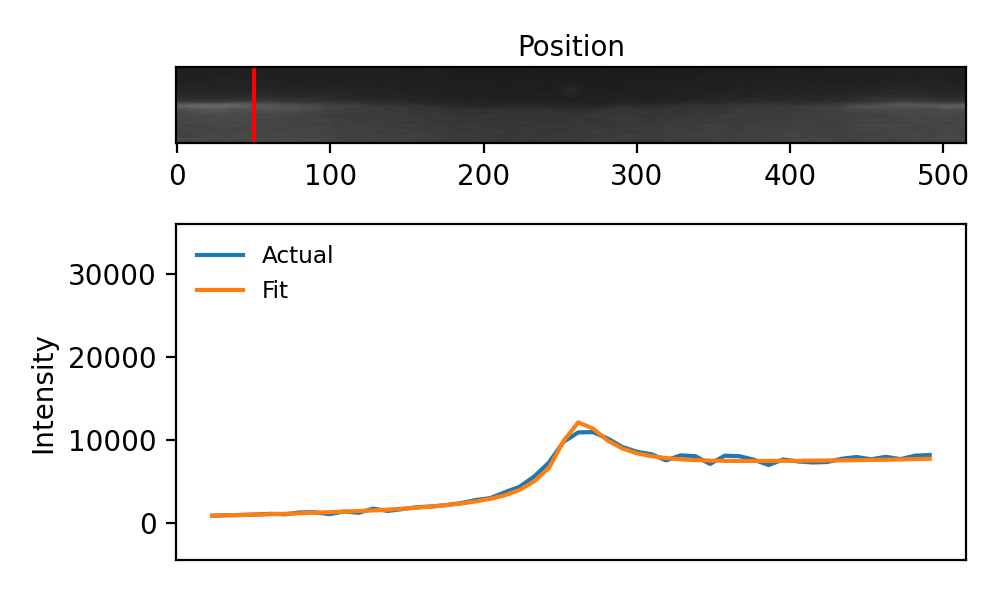

interactive(children=(IntSlider(value=0, description='Frame', max=33), FloatSlider(value=0.1, description='Pos…

In [7]:
iq.plot_fits(jupyter=True)

<IPython.core.display.Javascript object>


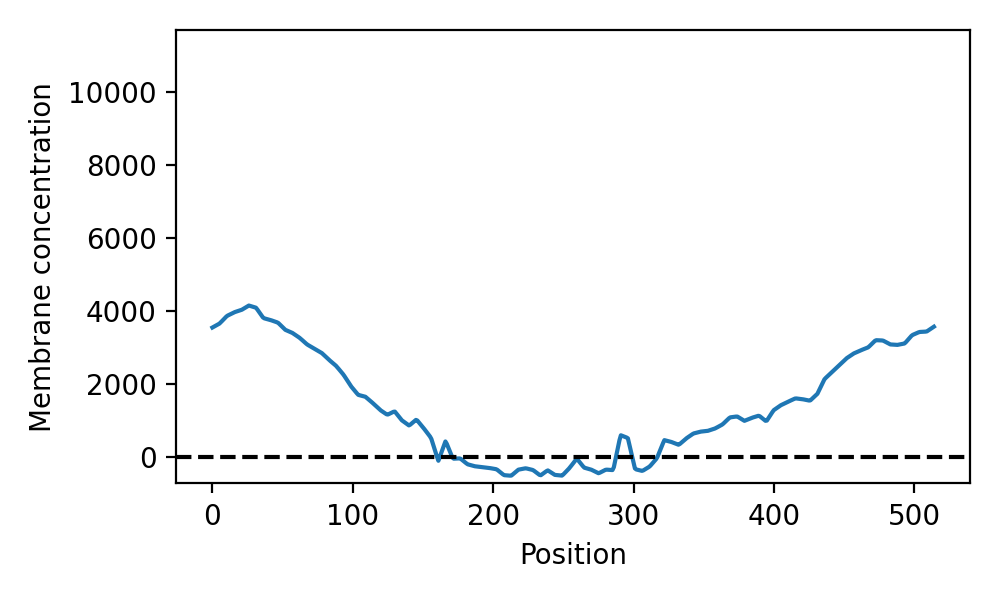

interactive(children=(IntSlider(value=0, description='Frame', max=33), Output()), _dom_classes=('widget-intera…

In [8]:
iq.plot_quantification(jupyter=True)

#### Save ROIs

In [9]:
for d, r in zip(direcs, iq.roi):
    np.savetxt(d + '/ROI_fitted.txt', r)

## Compile data

In [38]:
res = iq.compile_res()
res_grouped = res.sort_values('Position').groupby('Frame')
mems = res_grouped.apply(lambda x: bounded_mean_1d(x['Membrane signal'], [0.9, 0.1]))
cyts = res_grouped.apply(lambda x: bounded_mean_1d(x['Cytoplasmic signal'], [0.9, 0.1]))

In [39]:
df = pd.DataFrame()
for i, d in enumerate(direcs):
    p = {}
    p['Frame'] = i
    p['Path'] = d
    p['Folder'] = d.split('/')[-2]
    p['Name'] = d.split('/')[-1]
    p['Line'] = p['Folder'].split('_')[1] 
    p['Condition'] = {'lp637': 'Wild type', 'n2': 'N2', 'nwg376': 'GCN4', 'nwg377': 'GCN4', 'nwg381': 'C56S_GCN4', 
                      'nwg240': 'C56S', 'nwg398': 'L109R_GCN4', 'nwg399': 'L109R_GCN4', 'nwg338': 'L109R'}[p['Line']]
    p['Dosage'] = np.nanmean(iq.img[i] * make_mask([512, 512], offset_coordinates(iq.roi[i], 5)))        
    df = df.append(pd.DataFrame(p, index=[i]))
df['Mems'] = mems
df['Cyts'] = cyts
df['Ratio'] = mems / cyts
# df.to_csv('df.csv')

In [40]:
# print(df)

## Figs

#### Cyt, mem

In [41]:
def scatter(ax, df, cond, c, leg):
    _df = df[df['Condition'] == cond]
    ax.scatter(_df['Cyts'] / 1000, _df['Mems'] / 1000, c=c, label=leg)

<IPython.core.display.Javascript object>


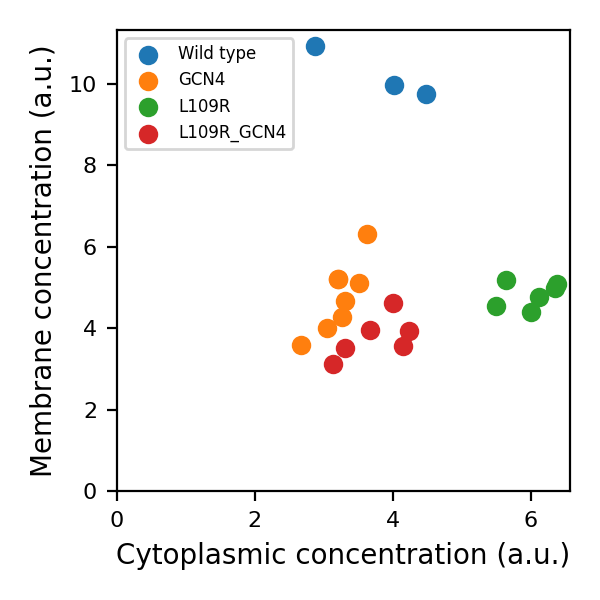

In [42]:
fig, ax = plt.subplots()
scatter(ax, df, 'Wild type', c='tab:blue', leg='Wild type')
scatter(ax, df, 'GCN4',  c='tab:orange', leg='GCN4')
# scatter(ax, df, 'C56S',  c='tab:green', leg='C56S')
# scatter(ax, df, 'C56S_GCN4',  c='tab:red', leg='C56S_GCN4')
scatter(ax, df, 'L109R',  c='tab:green', leg='L109R')
scatter(ax, df, 'L109R_GCN4',  c='tab:red', leg='L109R_GCN4')
ax.set_xlabel('Cytoplasmic concentration (a.u.)')
ax.set_ylabel('Membrane concentration (a.u.)')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.legend(fontsize=6)
ax.tick_params(axis='both', labelsize=8)
fig.set_size_inches(3, 3)
fig.tight_layout()
# fig.set_dpi(150)
# fig.savefig('Figs/cyt,mem.png')

#### Ratio

<IPython.core.display.Javascript object>


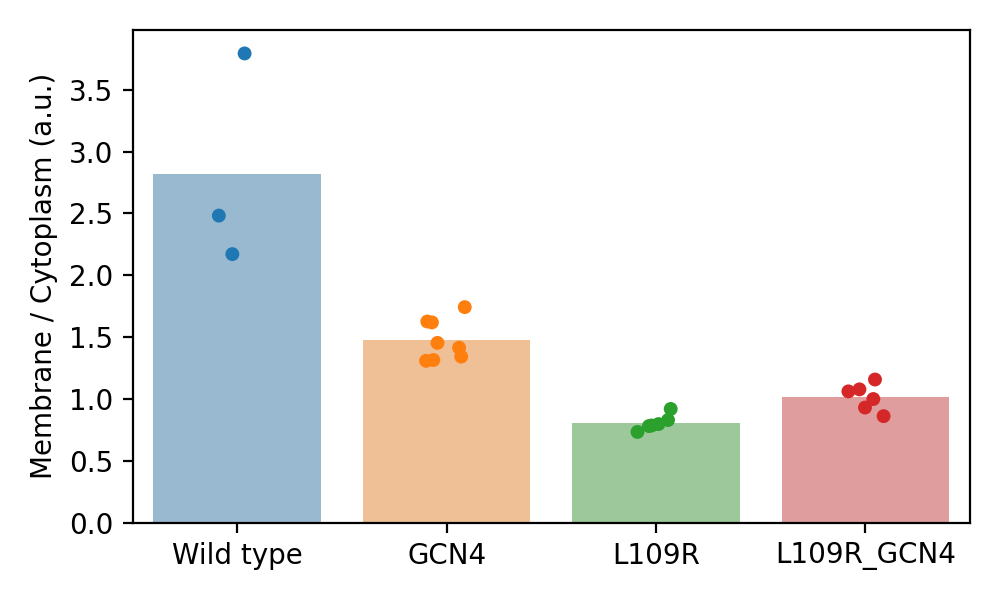

In [13]:
fig, ax = plt.subplots()
# df_filtered = df[df['Line'].isin(['lp637', 'nwg376', 'nwg377'])]
order = ['Wild type', 'GCN4', 'L109R', 'L109R_GCN4']
df_filtered = df[df['Condition'].isin(order)]
sns.stripplot(data=df_filtered, x='Condition', y='Ratio', ax=ax, order=order)
sns.barplot(data=df_filtered, x='Condition', y='Ratio', errwidth=0, alpha=0.5, ax=ax, order=order)
ax.set_ylim(bottom=0)
ax.set_ylabel('Membrane / Cytoplasm (a.u.)')
ax.set_xlabel('')
fig.set_size_inches(5, 3)
fig.tight_layout()
# fig.savefig('Figs/ratio bar.png')

#### Dosage

<IPython.core.display.Javascript object>


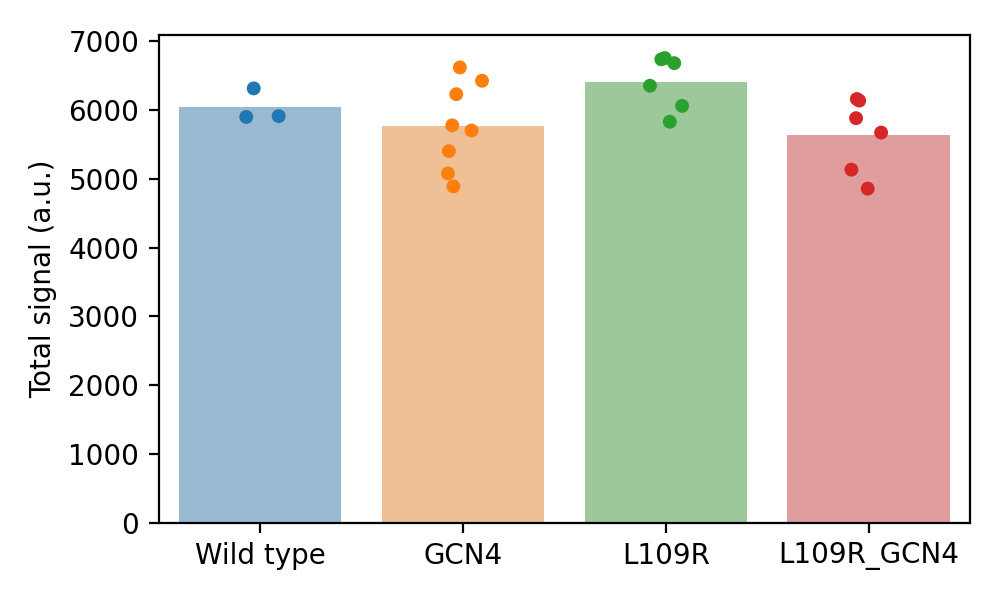

In [14]:
fig, ax = plt.subplots()
order = ['Wild type',  'GCN4', 'L109R', 'L109R_GCN4']
df_filtered = df[df['Condition'].isin(order)]
sns.stripplot(data=df_filtered, x='Condition', y='Dosage', ax=ax, order=order)
sns.barplot(data=df_filtered, x='Condition', y='Dosage', errwidth=0, alpha=0.5, ax=ax, order=order)
ax.set_ylim(bottom=0)
# ax.set_xticks([0, 1, 2])
# ax.set_xticklabels(['Wild type', 'NWG0376', 'NWG0377'])
ax.set_ylabel('Total signal (a.u.)')
ax.set_xlabel('')
fig.set_size_inches(5, 3)
fig.tight_layout()
# fig.savefig('Figs/dosage bar.png')

#### Concentration profiles

In [23]:
profs = np.array(res.groupby('Frame').apply(lambda x: np.array(x['Membrane signal']) / 1000))

def fold(array):
    return (array[:50][::-1] + array[50:]) / 2

profs_folded = np.array([fold(x) for x in profs])

def plot_profile(ax, df, cond, c, leg=None):
    frames = df[df['Condition'] == cond]['Frame']
    mean_profile, std_profile = np.mean(profs[frames], axis=0), np.std(profs[frames], axis=0)
    ax.plot(mean_profile, c=c, label=leg)
    ax.fill_between(np.arange(len(mean_profile)), mean_profile - std_profile, mean_profile + std_profile, alpha=0.2, 
                    color=c)

<IPython.core.display.Javascript object>


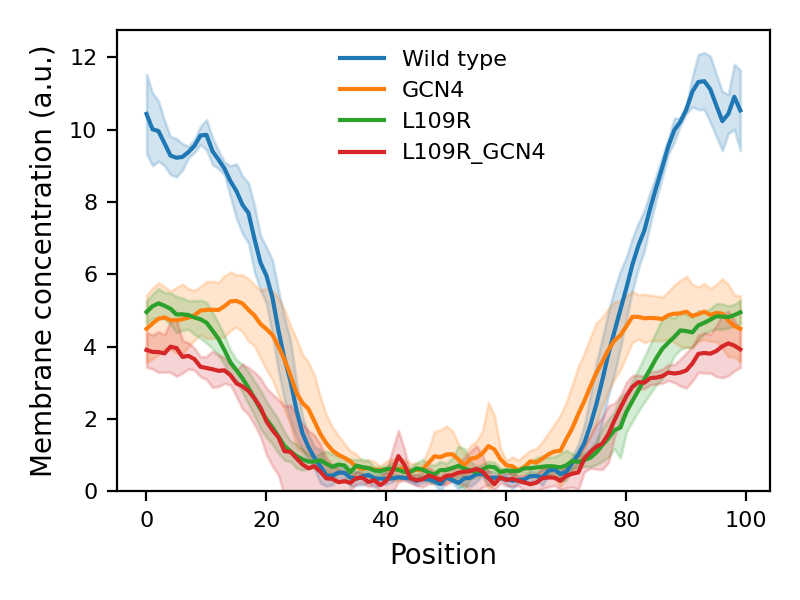

In [24]:
fig, ax = plt.subplots()
plot_profile(ax, df, 'Wild type', c='tab:blue', leg='Wild type')
plot_profile(ax, df, 'GCN4',  c='tab:orange', leg='GCN4')
plot_profile(ax, df, 'L109R',  c='tab:green', leg='L109R')
plot_profile(ax, df, 'L109R_GCN4',  c='tab:red', leg='L109R_GCN4')
ax.set_xlabel('Position')
ax.set_ylabel('Membrane concentration (a.u.)')
ax.set_ylim(bottom=0)
ax.legend(frameon=False, fontsize=8)
ax.tick_params(axis='both', labelsize=8)
fig.set_size_inches(4, 3)
fig.tight_layout()
# fig.savefig('Figs/concentration profiles.png')

#### Example images

In [17]:
def func(path):
    img = load_image(path + '/af_corrected.tif')
    roi = np.loadtxt(path + '/ROI.txt')
    img_rotated = rotated_embryo(img, roi, l=250, h=200, order=3)
    return img_rotated

<IPython.core.display.Javascript object>


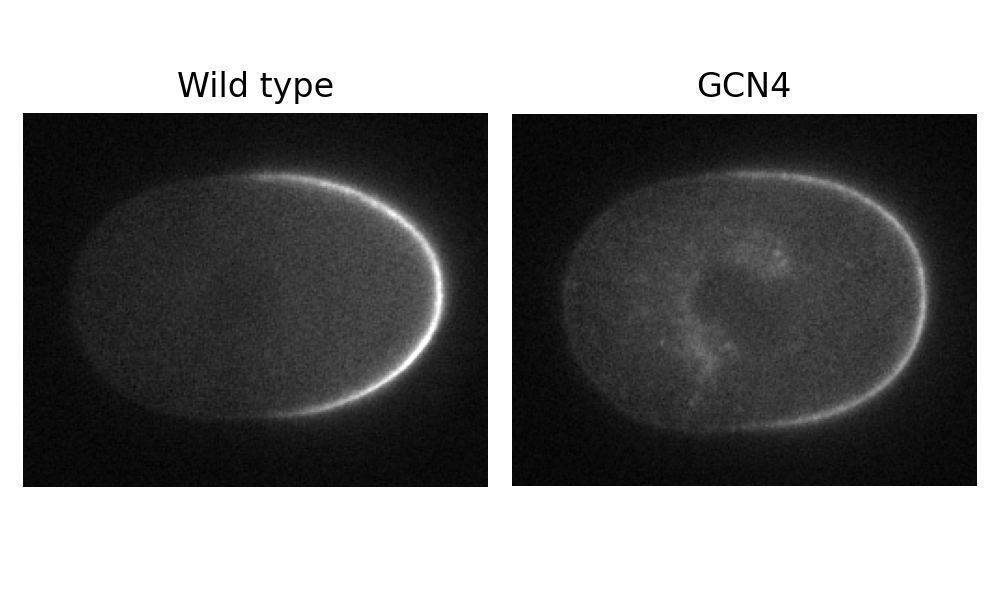

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(func('/Users/blandt/Desktop/Analysis/Experiments/e2107__gcn4/210722_lp637_tom4,15,60/02'), 
           vmin=-1000, vmax=30000, cmap='gray')
ax2.imshow(func('/Users/blandt/Desktop/Analysis/Experiments/e2107__gcn4/210722_nwg376_tom4,15,60/00'), 
           vmin=-1000, vmax=30000, cmap='gray')
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Wild type')
ax2.set_title('GCN4')
fig.tight_layout()
fig.set_size_inches(5, 3)
# fig.savefig('Figs/embryos.png')